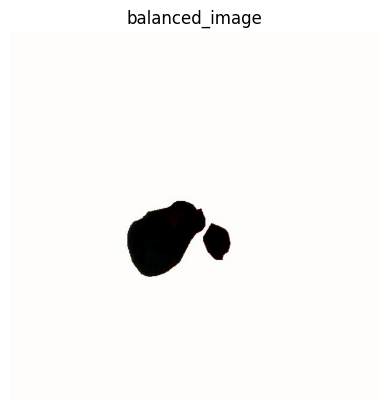

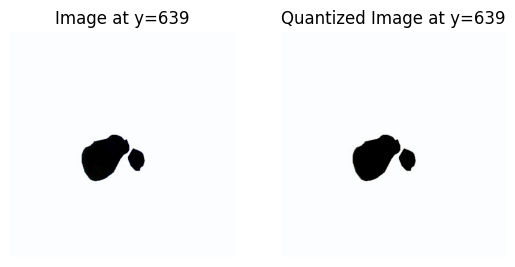

대표 색상 비율: {'White': 0, 'Gray': 0, 'Black': 98.29217960577813, 'Yellow': 1.7078203942218744, 'Orange': 0, 'Red': 0, 'Green': 0, 'Pink': 0, 'Purple': 0, 'Brown': 0}
감지된 위험 색상: ['Black']
대표 색상 비율: {'White': 0, 'Gray': 0, 'Black': 98.29217960577813, 'Yellow': 1.7078203942218744, 'Orange': 0, 'Red': 0, 'Green': 0, 'Pink': 0, 'Purple': 0, 'Brown': 0}
감지된 위험 색상: ['Black']


In [17]:
import cv2
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
# 정렬된 색상 카테고리 (딕셔너리)
sorted_color_categories = {
    "White": ["#FFFFFF", "#F5F5F5", "#E0E0E0"],
    "Gray": ["#808080", "#A9A9A9", "#696969"],
    "Black": ["#000000", "#2C2C2C", "#1C1C1C"],
    "Yellow": ["#FFFF00", "#FFFFE0", "#FFD700"],
    "Orange": ["#FFA500", "#FFCC99", "#FF8C00"],
    "Red": ["#FF0000", "#FFA07A", "#8B0000", "#854334"],
    "Green": ["#008000", "#98FB98", "#006400"],
    "Pink": ["#FFC0CB", "#FFB6C1", "#FF69B4"],
    "Purple": ["#800080", "#DA70D6", "#4B0082"],
    "Brown": ["#8B4513", "#D2B48C", "#4B3621", '#7B3F00', '#5C4033', '#6A482D', '#8B4513', '#805D47', "#9B7A4D", "#845B3B", "#664B2E", "#A07429", "#6F5232"]
}

# 위험 색상은 Brown을 제외한 나머지 카테고리입니다.
danger_color_categories = {k: v for k, v in sorted_color_categories.items() if k != 'Brown'}

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(color):
    return "#{:02x}{:02x}{:02x}".format(color[0], color[1], color[2])

def perceptual_color_quantization(image, color_palette):
    height, width, _ = image.shape
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 색변환
    quantized_image = image.copy()  # 입력 이미지를 복사하여 양자화된 이미지를 생성
    
    white_threshold = np.array([245, 245, 245])  # 하얀색으로 간주할 임계값 설정
    
    for y in range(height):
        for x in range(width):
            pixel_color = image[y, x]
            if np.all(pixel_color >= white_threshold):  # 하얀색 배경은 처리하지 않음
                continue
            closest_color = min(color_palette, key=lambda color: np.linalg.norm(pixel_color - color))
            quantized_image[y, x] = closest_color
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Image at y={y}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(quantized_image)
    plt.title(f"Quantized Image at y={y}")
    plt.axis('off')
    plt.show()
    return quantized_image

def analyze_image_colors(quantized_image, danger_color_categories, threshold=15.0):
    # 하얀색으로 간주할 임계값 설정 (예: 약간의 여유를 둠)
    white_threshold = np.array([245, 245, 245])

    # 이미지를 2차원 배열로 평평하게 만듭니다.
    flat_image = quantized_image.reshape(-1, 3)
    
    # 하얀색이 아닌 픽셀만 선택
    non_white_pixels = [tuple(pixel) for pixel in flat_image if not np.all(pixel >= white_threshold)]
    
    # 각 색상의 출현 빈도를 계산합니다.
    color_counts = Counter(non_white_pixels)
    if not color_counts:
        # 비하얀 픽셀이 없을 경우 처리: 여기서는 None으로 반환하거나 기본값 설정
        return None, [], {}

    # 위험 색상 존재 여부 및 비율 확인
    category_percentages = {k: 0 for k in sorted_color_categories.keys()}
    total_non_white_pixels = len(non_white_pixels)

    for category, colors in sorted_color_categories.items():
        for color in colors:
            color_tuple = hex_to_rgb(color)
            if color_tuple in color_counts:
                percentage = (color_counts[color_tuple] / total_non_white_pixels) * 100
                category_percentages[category] += percentage

    # 위험 색상 판별
    detected_danger_colors = [category for category, percentage in category_percentages.items()
                              if percentage >= threshold and category in danger_color_categories]

    return category_percentages, detected_danger_colors

def analyze_image(image, sorted_color_categories, danger_color_categories):
    # 이미지를 주어진 팔레트로 양자화
    all_colors_rgb = [hex_to_rgb(color) for colors in sorted_color_categories.values() for color in colors]
    quantized_image = perceptual_color_quantization(image, all_colors_rgb)
    
    # 함수 호출 예시
    threshold_value = 15.0  # 15% 이상의 색상만 위험 등급에 포함
    category_percentages, detected_danger_colors = analyze_image_colors(quantized_image, danger_color_categories, threshold=threshold_value)

    print(f"대표 색상 비율: {category_percentages}")
    print(f"감지된 위험 색상: {detected_danger_colors}")

    # 결과를 반환합니다.
    return category_percentages, detected_danger_colors

if __name__ == "__main__":
    # image = cv2.imread("/root/ai/dataset/human_poo/classification_aug_apply/train/1/Type1_iter3_jpg.rf.120ab2fecf2da5c5636192b9a1f1e4af_aug_93.jpg")
    # image = cv2.imread("/root/ai/dataset/puppy_poo/dataset_cls_train_aug_apply/train/2/1671179453042_jpg.rf.a0cbcb5c212d818bdf3bce0ef6826ca5.jpg")
    # image = cv2.imread("/root/ai/dataset/puppy_poo/dataset_cls_train_aug_apply/train/2/LackOfWater_0_jpg.rf.898e6edc2939a0a5b9d78c86bba30ad8.jpg")
    # image = cv2.imread("/root/ai/dataset/puppy_poo/dataset_cls_train_aug_apply/train/7/Diarrhoea_14_jpg.rf.63f0a7f8449f31f771b490de2853151a.jpg")
    image = cv2.imread("/root/ai/dataset/puppy_poo/dataset_cls_train_aug_apply/train/7/Diarrhoea_309_jpg.rf.79da5532346844f92a59762b658a9cb3.jpg")
    # image = cv2.imread("/root/ai/dataset/puppy_poo/dataset_cls_train_aug_apply/train/7/Diarrhoea_308_jpg.rf.74600d063b9a75b372ea76cf9d8bd3cb_aug_141.jpg")
    # image = cv2.imread("/root/ai/dataset/puppy_poo/dataset_cls_train_aug_apply/test/7/Diarrhoea_139_jpg.rf.78095def91543a10e53d3bb42f145cc5.jpg")
    # 이미지에서 색상 분석을 수행합니다.
    category_percentages, detected_danger_colors = analyze_image(image, sorted_color_categories, danger_color_categories)

    print(f"대표 색상 비율: {category_percentages}")
    print(f"감지된 위험 색상: {detected_danger_colors}")